In [1]:
# ---- > Preprocessing & Clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)  # simple reproducibility

# Load the cleaned data saved previously at 01_EDA
clean_path = "C:/pynew/Lib/Final Project New/US_Airline_Fares_Clean.csv"
df = pd.read_csv(clean_path)
print("Clean dataset shape:", df.shape)

Clean dataset shape: (237985, 15)


In [2]:
# We separate categorical and numeric columns based on df.info():
# - object dtype (text) -> categorical
# - int64/float64 with continuous values -> numeric
# - Year and quarter are numbers, but we treat them as categories -labels of time.

# 2.1.  Separate categorical and numeric columns
cat_cols = ["city1", "city2", "airport_1", "airport_2", 
            "carrier_lg", "carrier_low", "Year", "quarter"]
num_cols = ["nsmiles", "passengers", "large_ms", "fare_lg", 
            "lf_ms", "fare_low", "fare"]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['city1', 'city2', 'airport_1', 'airport_2', 'carrier_lg', 'carrier_low', 'Year', 'quarter']
Numeric columns: ['nsmiles', 'passengers', 'large_ms', 'fare_lg', 'lf_ms', 'fare_low', 'fare']


In [3]:
df["carrier_low"].value_counts().head()

carrier_low
WN    55500
AA    34735
DL    28916
US    23591
UA    20399
Name: count, dtype: int64

In [4]:
# ----carrier_low codes are IATA airline codes:
# G4 = Allegiant Air
# UA = United Airlines
# WN = Southwest Airlines
# AA = American Airlines
# DL = Delta Air Lines


In [5]:
# === 2.2: Encode categorical columns 

# We create dummies only for the most frequent carriers
# Top 3 carriers in the dataset: 
# WN = Southwest, AA = American, DL = Delta

df["carrier_is_WN"] = (df["carrier_low"] == "WN").astype(int)
df["carrier_is_AA"] = (df["carrier_low"] == "AA").astype(int)
df["carrier_is_DL"] = (df["carrier_low"] == "DL").astype(int)

print(df[["carrier_low","carrier_is_WN","carrier_is_AA","carrier_is_DL"]].head(11))

   carrier_low  carrier_is_WN  carrier_is_AA  carrier_is_DL
0           G4              0              0              0
1           UA              0              0              0
2           WN              1              0              0
3           AA              0              1              0
4           AA              0              1              0
5           WN              1              0              0
6           WN              1              0              0
7           WN              1              0              0
8           WN              1              0              0
9           WN              1              0              0
10          WN              1              0              0


In [6]:
# ---- 2.3: Scale numeric columns
from sklearn.preprocessing import StandardScaler

num_cols = ["nsmiles","passengers","large_ms","fare_lg","lf_ms","fare_low","fare"]
scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(df[num_cols]),
    columns=num_cols,
    index=df.index
)

print("Scaled numeric shape:", X_num.shape)
print(X_num.head(3))


Scaled numeric shape: (237985, 7)
    nsmiles  passengers  large_ms   fare_lg     lf_ms  fare_low      fare
0 -0.314065   -0.250528  1.532325 -1.711991  1.709730 -1.593637 -1.822815
1 -0.314065   -0.562004 -0.874168  0.035384 -0.976485 -0.513467 -0.106994
2 -0.871817   -0.204096  1.517907 -0.412842  1.699970 -0.062703 -0.434951


In [7]:
#--- 2.4: Build X for clustering

# We keep only the dummies we created, not all categories
cat_small = ["carrier_is_WN", "carrier_is_AA", "carrier_is_DL"]

# We combine numeric scaled + selected categorical dummies
X = pd.concat([X_num, df[cat_small]], axis=1)

print("Final X shape:", X.shape)
print(X.head(3))


Final X shape: (237985, 10)
    nsmiles  passengers  large_ms   fare_lg     lf_ms  fare_low      fare  \
0 -0.314065   -0.250528  1.532325 -1.711991  1.709730 -1.593637 -1.822815   
1 -0.314065   -0.562004 -0.874168  0.035384 -0.976485 -0.513467 -0.106994   
2 -0.871817   -0.204096  1.517907 -0.412842  1.699970 -0.062703 -0.434951   

   carrier_is_WN  carrier_is_AA  carrier_is_DL  
0              0              0              0  
1              0              0              0  
2              1              0              0  


In [8]:
# Explanation:
# Step 2.3 -> only the 7 numeric columns, already scaled.
# Step 2.4 -> added the 3 dummy columns (WN, AA, DL from step 2.2).
# So now X has 10 columns total, and this is what we will use for clustering.

In [10]:
#  STEP 3: Silhouette score 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use a sample to make it faster
sample = X.sample(10000, random_state=42)

ks = list(range(2, 11))   # test k = 2..10
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10)
    labels = km.fit_predict(sample)
    score = silhouette_score(sample, labels)
    sil_scores.append(score)

print("Silhouette scores:", sil_scores)


# Silhouette with the full dataset takes too long.
# We use a sample of 10,000 rows to get results faster.

Silhouette scores: [np.float64(0.26406012786268523), np.float64(0.24273778243493765), np.float64(0.25222647223694294), np.float64(0.21210329376008477), np.float64(0.2122711144856071), np.float64(0.2155959890652914), np.float64(0.21155704728897107), np.float64(0.20313488588258463), np.float64(0.1939879079891174)]


In [11]:
# Silhouette results: Best score is for k=2 (0.264).
# k=4 is also ok (0.252) but smaller. So the best choice is k=2 for this dataset.

In [14]:
# STEP 3.2 Apply KMeans with k=2 

best_k = 2
km_final = KMeans(n_clusters=best_k, n_init=10)
df["cluster"] = km_final.fit_predict(X)
# We add the cluster labels to df in a new column.

print("Cluster counts:")
print(df["cluster"].value_counts())


Cluster counts:
cluster
1    141786
0     96199
Name: count, dtype: int64


In [15]:
# Result of k=2:
# Cluster 1 has 141725 flights
# Cluster 0 has 96260 flights
# Next we will plot to see the difference

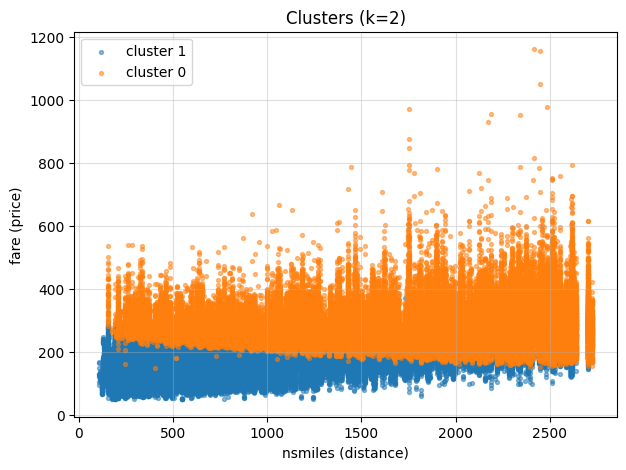

In [17]:
#  STEP 3.3. Scatter plot of clusters

plt.figure(figsize=(7,5))
for c in df["cluster"].unique():
    cluster_data = df[df["cluster"] == c]
    plt.scatter(cluster_data["nsmiles"], cluster_data["fare"], s=8, alpha=0.5, label=f"cluster {c}")

plt.title("Clusters (k=2)")
plt.xlabel("nsmiles (distance)")
plt.ylabel("fare (price)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


In [18]:
# From the plot:
# cluster 1 (blue) looks cheaper
# cluster 0 (orange) looks more expensive
# distance is mixed in both


In [21]:
# ------ STEP 4
# 4.1: PCA explained variance

from sklearn.decomposition import PCA

# Fit PCA on X (the 10 features from step 2.4)
pca = PCA()
pca.fit(X)

# variance of each component
var_ratio = pca.explained_variance_ratio_
print("Variance ratio:", var_ratio)

# cumulative variance (to see where to stop)
cum_var = var_ratio.cumsum()
print("Cumulative variance:", cum_var[:10])  # first 10 comps

Variance ratio: [0.45116825 0.2074228  0.12038135 0.08655255 0.05954263 0.02479599
 0.01864339 0.01727103 0.00960037 0.00462165]
Cumulative variance: [0.45116825 0.65859105 0.7789724  0.86552495 0.92506757 0.94986356
 0.96850695 0.98577798 0.99537835 1.        ]


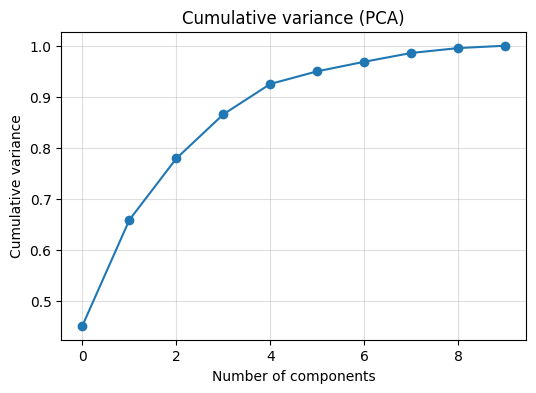

In [22]:
#  4.2: Plot cumulative variance 
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cum_var, marker="o")
plt.title("Cumulative variance (PCA)")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.grid(True, alpha=0.4)
plt.show()

# cumulative variance: comp3=0.77, comp4=0.86, comp5=0.92  

In [23]:
# cumulative variance = how much info is kept
# number of components = PCA new features
# curve > 0.90 at comp5 (0.92)
# after comp3 the gain is smaller

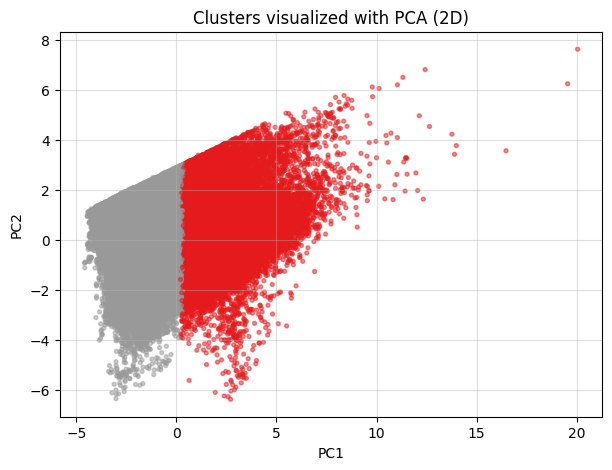

In [24]:
# 4.3: PCA 2D plot of clusters

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

plt.figure(figsize=(7,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=df["cluster"], cmap="Set1", s=8, alpha=0.5)
plt.title("Clusters visualized with PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.4)
plt.show()



In [26]:
# PCA 2D only shows clusters in new space (PC1, PC2)
# we can see separation, not perfect
# some points are far (outliers >15) but we cannot explain them here

In [30]:
# 4.5: Check outliers in PCA space >10

# Find rows where PC1 > 10
outliers = df.loc[X_pca2[:,0] > 10]

print("Outliers found:", outliers.shape[0])
print(outliers[["nsmiles", "fare", "passengers"]].head())

Outliers found: 31
       nsmiles    fare  passengers
4128      1750  779.36           8
16474     1750  972.76           3
27650     1784  608.23           2
29001     2342  645.48           1
42548     1900  583.41           1


In [28]:
# Outliers in PCA = flights with high fare + long distance + few passengers
# Example: fare > 848, passengers < 3

In [35]:
# 4.5:Check outliers in PC2 (low values)

outliers_pc2 = df.loc[X_pca2[:,1] < -6]

print("Outliers found:", outliers_pc2.shape[0])
print(outliers_pc2[["nsmiles", "fare", "passengers"]].head())


Outliers found: 10
        nsmiles    fare  passengers
59527       372  111.32        5827
78350      1139  116.37        6051
85950      1139  104.46        5958
202320     2510  398.74        8023
202345      372  111.25        6325


In [36]:
# Outliers in PC2 = flights with very high passengers (6000 to 8000)
# price is normal (100-400), distance can be short or long

In [37]:
# Central zone in PCA (PC1 -1..3, PC2 -2..2) has most flights
# these are normal flights with average distance, fare, passengers
# the clusters overlap more here

C:\pynew\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


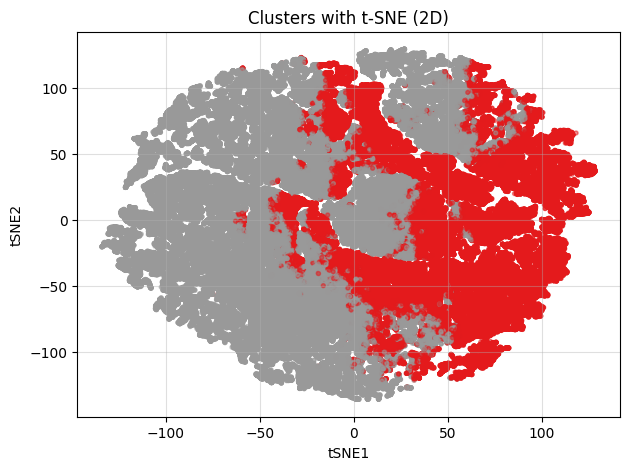

In [38]:
# ----STEP 5

#  5.1: t-SNE 2D visualization
from sklearn.manifold import TSNE

tsne2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne2d.fit_transform(X)

plt.figure(figsize=(7,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df["cluster"], cmap="Set1", s=8, alpha=0.5)
plt.title("Clusters with t-SNE (2D)")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.grid(True, alpha=0.4)
plt.show()

